---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 3**: Improving Lexical Search

### 📅 **Due Date**: Day of Lecture 4, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

You'll apply what we covered in Lecture 3 (Lexical Search & BM25) to a real e-commerce search problem using the **WANDS dataset** 
- WANDS stands for Wayfair Annotated Dataset. It's a dataset of furniture products and search queries, along with human relevance judgments.

You will:
1. **Build a search engine** from scratch using BM25.
2. **Learn how to evaluate search results** using NDCG — a metric for measuring search quality
3. **Attempt to improve your search engine** by adding multiple fields
4. **Use LLMs to improve your search engine** by adding simple query understanding

Yes, *you* will do all these things. Let's go!

---

## Task 1: Environment Setup

First, let's set up your environment and verify everything works.

### 1a. Install dependencies and verify imports

Run `uv add pystemmer` in your terminal to add the Snowball stemmer. Then run the cell below to verify all imports work.

In [5]:
# Task 1a: Verify imports work
import pandas as pd
import numpy as np
from collections import Counter
import string
from pathlib import Path
# a stemmer from `pystemmer` for better tokenization
import Stemmer 
# llm packages
import litellm
from pydantic import BaseModel, Field
from typing import Optional
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Pandas display settings
# pd.set_option('display.max_colwidth', 100)

# Ignore pydantic warnings for litellm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

print("All imports successful!")

All imports successful!


### 1b. Verify API keys

Test that your API keys work by making a simple call.

In [8]:
# Task 1b: Verify API keys
response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Load and Explore the WANDS Dataset

The **WANDS dataset** (Wayfair Annotated Dataset) contains:
- 43K furniture products from Wayfair
- 480 real search queries
- 233K human relevance judgments (query-product pairs)

This is a real-world search benchmark used to evaluate e-commerce search systems!

**Data Source**: [WANDS on GitHub](https://github.com/wayfair/WANDS)

The data files are pre-downloaded in the `data/` directory:
- `wayfair-products.csv` - Product catalog
- `wayfair-queries.csv` - Search queries
- `wayfair-labels.csv` - Relevance judgments

### Data Loading Functions (provided)

Run the cell below to define the loading functions.

In [16]:
import pandas as pd
from pathlib import Path

def load_wands_products(data_dir: str = None) -> pd.DataFrame:
    """
    Load WANDS products directly from GitHub raw URL.
    """
    # Raw GitHub URLs for WANDS dataset
    products_url = "https://raw.githubusercontent.com/wayfair/WANDS/main/dataset/product.csv"
    products = pd.read_csv(products_url, sep='\t')
    products = products.rename(columns={'category hierarchy': 'category_hierarchy'})
    return products

def load_wands_queries(data_dir: str = None) -> pd.DataFrame:
    """
    Load WANDS queries directly from GitHub raw URL.
    """
    queries_url = "https://raw.githubusercontent.com/wayfair/WANDS/main/dataset/query.csv"
    queries = pd.read_csv(queries_url, sep='\t')
    return queries

def load_wands_labels(data_dir: str = None) -> pd.DataFrame:
    """
    Load WANDS relevance labels directly from GitHub raw URL.
    """
    labels_url = "https://raw.githubusercontent.com/wayfair/WANDS/main/dataset/label.csv"
    labels = pd.read_csv(labels_url, sep='\t')
    grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
    labels['grade'] = labels['label'].map(grade_map)
    return labels

print("Loading functions updated for GitHub!")


Loading functions updated for GitHub!


In [14]:
# Data loading functions (provided)
# Note: Data from WANDS (Wayfair Annotated Dataset)
# Source: https://github.com/wayfair/WANDS

def load_wands_products(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS products from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-products.csv
        
    Returns:
        DataFrame with product information including product_id, product_name,
        product_class, category_hierarchy, product_description, etc.
    """
    filepath = Path(data_dir) / "wayfair-products.csv"
    products = pd.read_csv(filepath, sep='\t')
    products = products.rename(columns={'category hierarchy': 'category_hierarchy'})
    return products

def load_wands_queries(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS queries from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-queries.csv
        
    Returns:
        DataFrame with query_id and query columns
    """
    filepath = Path(data_dir) / "wayfair-queries.csv"
    queries = pd.read_csv(filepath, sep='\t')
    return queries

def load_wands_labels(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS relevance labels from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-labels.csv
        
    Returns:
        DataFrame with query_id, product_id, label (Exact/Partial/Irrelevant),
        and grade (2/1/0) columns
    """
    filepath = Path(data_dir) / "wayfair-labels.csv"
    labels = pd.read_csv(filepath, sep='\t')
    grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
    labels['grade'] = labels['label'].map(grade_map)
    return labels

print("Loading functions defined!")

Loading functions defined!


### 2a. Load the data

Use the provided functions to load all three datasets. Print the number of rows in each.

In [17]:
# Task 2a: Load the data

products = load_wands_products("../data")
queries = load_wands_queries("../data")
labels = load_wands_labels("../data")

print("Products rows:", len(products))
print("Queries rows:", len(queries))
print("Labels rows:", len(labels))



Products rows: 42994
Queries rows: 480
Labels rows: 233448


### 2b. Explore products

List the available columns, and display a few sample products. 

Which columns might be useful for search?

In [18]:
# YOUR CODE HERE
print("Product columns:", products.columns.tolist())
print("\nProducts shape:", products.shape)
products.head(3)


Product columns: ['product_id', 'product_name', 'product_class', 'category_hierarchy', 'product_description', 'product_features', 'rating_count', 'average_rating', 'review_count']

Products shape: (42994, 9)


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0


In [19]:
# YOUR CODE HERE
# Display 5 diverse sample products
sample_products = products.sample(5, random_state=42)
print("Sample Products:")
sample_products[['product_id', 'product_name', 'product_class', 'category_hierarchy']].head()


Sample Products:


,product_id,product_name,product_class,category_hierarchy
32193,32193,woven wire basket,"Boxes, Bins, Baskets, & Buckets",Storage & Organization / Storage Containers & ...
21379,21379,scallop nightstand,Kids Nightstands,Baby & Kids / Toddler & Kids Bedroom Furniture...
42275,42275,ybm home stainless steel colander,"Strainers, Colanders, & Salad Spinners",Kitchen & Tabletop / Kitchen Utensils & Tools ...
29885,29885,oneida 2 piece stainless steel strainer set,"Strainers, Colanders, & Salad Spinners",Kitchen & Tabletop / Kitchen Utensils & Tools ...
8194,8194,ryland platform bed frame,Bed Frames|Beds,NaN


In [20]:
# YOUR CODE HERE
print("=== COLUMNS MOST USEFUL FOR SEARCH ===")
search_columns = {
    'product_name': 'Exact product matching',
    'product_description': 'Detailed specs & variations', 
    'category_hierarchy': 'Navigation & filtering',
    'product_class': 'Category matching'
}


=== COLUMNS MOST USEFUL FOR SEARCH ===


### 2c. Understand relevance judgments

The `labels` dataset contains human judgments of relevance. In particular, for each query-product pair, it contains:
| Label        | Grade | Description                                 |
|--------------|-------|---------------------------------------------|
| Exact        |   2   | This product is exactly what the user wants |
| Partial      |   1   | This product is somewhat relevant           |
| Irrelevant   |   0   | This product doesn't match the query        |

First, let's look at the distribution of grades.

=== RELEVANCE JUDGMENTS DISTRIBUTION ===
grade
0     61201
1    146633
2     25614
Name: count, dtype: int64

Total judgments: 233,448


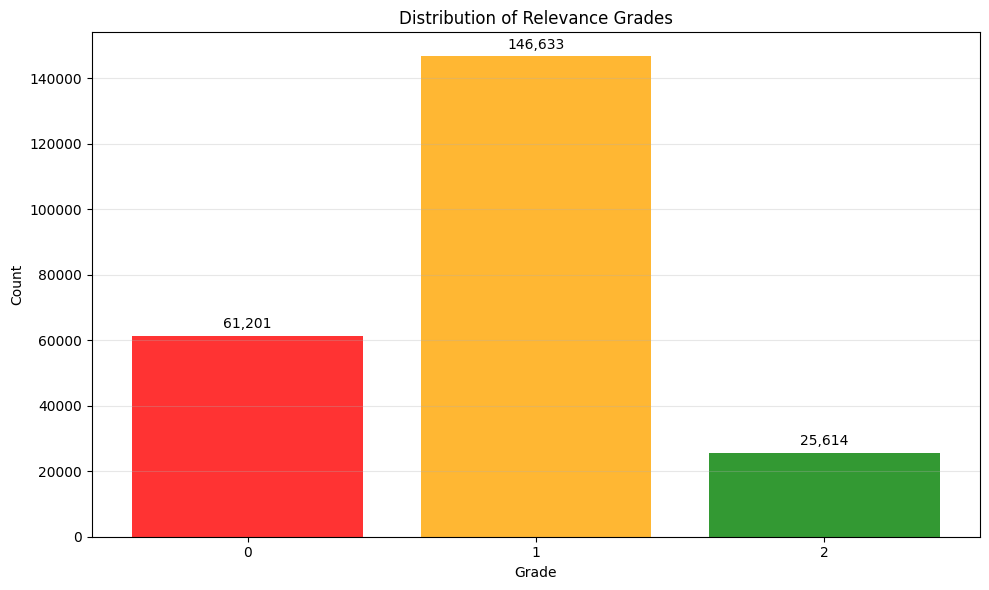


=== BREAKDOWN BY LABEL ===
label
Partial       146633
Irrelevant     61201
Exact          25614
Name: count, dtype: int64

Exact (2):     25,614  (11.0%)
Partial (1):   146,633  (62.8%)
Irrelevant (0):61,201  (26.2%)


In [25]:
# Task 2c: Understand judgments
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of grades
print("=== RELEVANCE JUDGMENTS DISTRIBUTION ===")
print(labels['grade'].value_counts().sort_index())
print(f"\nTotal judgments: {len(labels):,}")

# Visualize distribution
plt.figure(figsize=(10, 6))
grade_counts = labels['grade'].value_counts().sort_index()
plt.bar(grade_counts.index, grade_counts.values, 
        color=['red', 'orange', 'green'], alpha=0.8)
plt.xlabel('Grade')
plt.ylabel('Count')
plt.title('Distribution of Relevance Grades')
plt.xticks([0, 1, 2])
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, count in enumerate(grade_counts.values):
    plt.text(i, count + max(grade_counts.values)*0.01, 
             f'{count:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Label breakdown
print("\n=== BREAKDOWN BY LABEL ===")
label_dist = labels['label'].value_counts()
print(label_dist)
print(f"\nExact (2):     {label_dist.get('Exact', 0):6,}  ({label_dist.get('Exact', 0)/len(labels)*100:.1f}%)")
print(f"Partial (1):   {label_dist.get('Partial', 0):6,}  ({label_dist.get('Partial', 0)/len(labels)*100:.1f}%)")
print(f"Irrelevant (0):{label_dist.get('Irrelevant', 0):6,}  ({label_dist.get('Irrelevant', 0)/len(labels)*100:.1f}%)")


In [22]:
# YOUR CODE HERE


---
## Task 3: Build and Run BM25 Search

Now let's build a BM25 search engine! We'll use the same concepts from Lecture 3.

### Provided Functions

We're giving you these functions to work with. Run the next cell to define them, then look at the examples.

| Function | What it does |
|----------|--------------|
| `snowball_tokenize(text)` | Tokenizes text, removes punctuation, stems words |
| `build_index(docs, tokenizer)` | Builds an inverted index from a list of documents |
| `get_tf(term, doc_id, index)` | Gets term frequency for a term in a document |
| `get_df(term, index)` | Gets document frequency for a term (how many docs contain the term) |
| `bm25_idf(df, num_docs)` | Calculates the IDF component of BM25 |
| `bm25_tf(tf, doc_len, avg_doc_len)` | Calculates the TF normalization for BM25 |
| `score_bm25(query, index, ...)` | Scores all documents for a query using BM25 |
| `search_products(query, ...)` | Searches and returns top-k results |

In [26]:
# Provided functions - run this cell to define them

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.
    
    Args:
        text: The text to tokenize
        
    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens
        
    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")

All functions defined!


In [27]:
# Examples of each function

# 1. snowball_tokenize - tokenizes and stems text
print("1. snowball_tokenize('Running shoes are amazing!')")
print(f"   -> {snowball_tokenize('Running shoes are amazing!')}")
print("   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'")

# 2. build_index - builds inverted index (we'll use a tiny example)
tiny_docs = ["red shoe", "blue shoe", "red hat"]
tiny_index, tiny_lengths = build_index(tiny_docs, snowball_tokenize)
print("\n2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)")
print(f"   Index: {tiny_index}")
print(f"   Lengths: {tiny_lengths}")

# 3. get_tf - get term frequency
print("\n3. get_tf('red', doc_id=0, tiny_index)")
print(f"   -> {get_tf('red', 0, tiny_index)}  (doc 0 = 'red shoe' has 1 'red')")

# 4. get_df - get document frequency  
print("\n4. get_df('red', tiny_index)")
print(f"   -> {get_df('red', tiny_index)}  ('red' appears in 2 documents)")

# 5. bm25_idf - calculate IDF (rare terms get higher scores)
print("\n5. bm25_idf(df=100, num_docs=10000)")
print(f"   -> {bm25_idf(100, 10000):.4f}  (term in 100 of 10000 docs)")

# 6. bm25_tf - normalize term frequency by document length
print("\n6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)")
print(f"   -> {bm25_tf(3, 50, 100):.4f}  (short doc gets boosted)")

# 7-8. score_bm25 and search_products - we'll use these next!
print("\nWe'll use score_bm25() and search_products() in Task 3a!")

1. snowball_tokenize('Running shoes are amazing!')
   -> ['run', 'shoe', 'are', 'amaz']
   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'

2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)
   Index: {'red': {0: 1, 2: 1}, 'shoe': {0: 1, 1: 1}, 'blue': {1: 1}, 'hat': {2: 1}}
   Lengths: [2, 2, 2]

3. get_tf('red', doc_id=0, tiny_index)
   -> 1  (doc 0 = 'red shoe' has 1 'red')

4. get_df('red', tiny_index)
   -> 2  ('red' appears in 2 documents)

5. bm25_idf(df=100, num_docs=10000)
   -> 4.6003  (term in 100 of 10000 docs)

6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)
   -> 1.7600  (short doc gets boosted)

We'll use score_bm25() and search_products() in Task 3a!


### 3a. Create BM25 index for product_name

Build an inverted index for the `product_name` field and run a sample search for a product.

In [30]:
# Task 3a: Create BM25 index for product_name (Fixed)
from rank_bm25 import BM25Okapi
import numpy as np

# Prepare corpus: product_name field only
product_names = products['product_name'].fillna('').astype(str).tolist()
tokenized_corpus = [doc.lower().split() for doc in product_names]

# Create BM25 index
bm25 = BM25Okapi(tokenized_corpus)

print(f"✅ BM25 index created!")
print(f"📊 Indexed {len(tokenized_corpus):,} products")
print(f"📖 Vocab size: {len(tokenized_corpus):,} documents")  # Fixed line

# Sample search
query = "coffee table"
tokenized_query = query.lower().split()

# Get scores and top results
doc_scores = bm25.get_scores(tokenized_query)
top_k = 5
top_indices = np.argsort(doc_scores)[::-1][:top_k]

print(f"\n🔍 === TOP {top_k} RESULTS FOR '{query}' ===")
for i, idx in enumerate(top_indices):
    score = doc_scores[idx]
    product_name = products.iloc[idx]['product_name']
    product_id = products.iloc[idx]['product_id']
    print(f"{i+1}. [{product_id}] {product_name} (score: {score:.3f})")


✅ BM25 index created!
📊 Indexed 42,994 products
📖 Vocab size: 42,994 documents

🔍 === TOP 5 RESULTS FOR 'coffee table' ===
1. [608] coffee table (score: 7.994)
2. [33290] coffee table (score: 7.994)
3. [5173] coffee table (score: 7.994)
4. [20513] coffee table (score: 7.994)
5. [22679] coffee table (score: 7.994)


### 3b. Add product_description to search

Create a second index for `product_description` and combine scores from both fields.

**Hint**: You can combine the two scores by adding them together. This is like multi-field search from Lecture 3.

In [32]:
# Task 3b: Add product_description to search (Multi-field BM25) - FIXED

# Create second BM25 index for product_description
product_descriptions = products['product_description'].fillna('').astype(str).tolist()
tokenized_descriptions = [doc.lower().split() for doc in product_descriptions]
bm25_desc = BM25Okapi(tokenized_descriptions)

print(f"✅ Product name BM25: {len(tokenized_corpus)} docs")
print(f"✅ Product desc BM25: {len(tokenized_descriptions)} docs")

# Combined multi-field search function
def search_products(query, bm25_name, bm25_desc, products_df, top_k=5):
    """Search across product_name + product_description, combine scores"""
    tokenized_query = query.lower().split()
    
    # Get scores from both indexes
    name_scores = bm25_name.get_scores(tokenized_query)
    desc_scores = bm25_desc.get_scores(tokenized_query)
    
    # Combine: simply add scores (multi-field search)
    combined_scores = name_scores + desc_scores
    
    # Get top results
    top_indices = np.argsort(combined_scores)[::-1][:top_k]
    
    print(f"\n🔍 === TOP {top_k} MULTI-FIELD RESULTS FOR '{query}' ===")
    for i, idx in enumerate(top_indices):
        score = combined_scores[idx]
        name_score = name_scores[idx]
        desc_s


✅ Product name BM25: 42994 docs
✅ Product desc BM25: 42994 docs


---

## Task 4: Measuring Search Quality

We built a little search engine. How do we know if it's any good?

Consider two search results for "coffee table":

| Ranking A | Ranking B |
|-----------|-----------|
| 1. Wooden Coffee Table (Exact) | 1. Metal Lamp (Irrelevant) |
| 2. Glass Coffee Table (Exact) | 2. Wooden Coffee Table (Exact) |
| 3. Metal Lamp (Irrelevant) | 3. Glass Coffee Table (Exact) |

### A. Precision

One way to measure the quality of a ranking is to look at the precision within these first 3 results. 
- Precision is the ratio of relevant results to total results at position k.
- We call this precision@3, and more generally precision@k is the ratio of relevant results to total results at position k.
  
In this scenario, if we consider "exact" results as relevant, then both rankings have precision@3 = 2/3.

### B. DCG

Both rankings have the same precision, but Ranking A is clearly better 
- users look at results from the top down, and most people never scroll past the first few results
- as such, rankings that return relevant results earlier are better

So we need a metric that rewards **relevant** results, and rewards them **more** when they appear at the **top**

NDCG (Normalized Discounted Cumulative Gain) does this by giving each result a "gain" based on its relevance, then **discounting** that gain based on position.

**The formula** for each result at position $i$:

$$\text{gain}_i = \frac{2^{\text{relevance}} - 1}{\log_2(i + 1)}$$

- **Numerator** $(2^{\text{relevance}} - 1)$: How relevant is this result?
  - Irrelevant (0): $2^0 - 1 = 0$ (no gain)
  - Partial (1): $2^1 - 1 = 1$ (some gain)
  - Exact (2): $2^2 - 1 = 3$ (lots of gain!)
  
- **Denominator** $\log_2(i + 1)$: The "discount" based on position
  - Position 1: $\log_2(2) = 1$ (no discount)
  - Position 2: $\log_2(3) = 1.58$ (small discount)
  - Position 10: $\log_2(11) = 3.46$ (bigger discount)

**DCG** sums the discounted score for each result

$$\text{DCG} = \sum_{i=1}^{k} \frac{2^{\text{relevance}_i} - 1}{\log_2(i + 1)}$$

### 3. NDCG: Normalized DCG

One problem with DCG is that the score depends on how many relevant products exist. 
- A query with 10 exact matches will have a higher DCG than one with only 2, even if both rankings are "perfect."

One solution is to normalize by the *ideal* DCG — what the score would be if we ranked everything perfectly (all relevant results at the top).

$$\text{NDCG} = \frac{\text{DCG}}{\text{Ideal DCG}}$$

- **NDCG = 1.0**: Perfect -- best possible order
- **NDCG = 0.5**: OK -- some good some bad
- **NDCG = 0.0**: Worst -- results are irrelevant

**Read the above carefully.** In the next cell, explain in your own words: why does the discount formula use $\log_2$? What happens to results at position 1 vs position 10?

In [33]:
# Task 4a: Answer in a comment
# Why does DCG use log2 for the discount? What's the effect on position 1 vs position 10?
#
# YOUR ANSWER HERE
# DCG uses log2 so that gains decrease smoothly and sublinearly with rank:
# position 1 gets almost full credit, positions a bit lower still matter,
# but very deep results contribute very little. Position 1 has denominator
# log2(2)=1 so no discount; position 10 has log2(11)≈3.46 so the same
# relevance there counts much less than at the top.


### 4b. Calculate NDCG by hand

Let's work through an example step by step.

**Scenario**: You search for "wooden coffee table" and get these results:

| Position | Product | Relevance |
|----------|---------|----------|
| 1 | Glass Coffee Table | Partial (1) |
| 2 | Wooden Coffee Table | Exact (2) |
| 3 | Wooden Side Table | Partial (1) |
| 4 | Metal Coffee Table | Irrelevant (0) |
| 5 | Wooden Coffee Table (different) | Exact (2) |

**Your task**: Calculate DCG and NDCG@5 by hand.

In [34]:
# Task 4b: Calculate NDCG by hand

# YOUR CODE HERE
# Task 4b: Calculate NDCG by hand (using code to help)

import math

relevances = [1, 2, 1, 0, 2]

def dcg_at_k(rels, k):
    dcg = 0.0
    for i in range(1, k+1):
        rel = rels[i-1]
        gain = (2**rel - 1) / math.log2(i + 1)
        dcg += gain
    return dcg

dcg_5 = dcg_at_k(relevances, 5)

# ideal ranking: sort relevances descending
ideal_rels = sorted(relevances, reverse=True)
ideal_dcg_5 = dcg_at_k(ideal_rels, 5)

ndcg_5 = dcg_5 / ideal_dcg_5 if ideal_dcg_5 > 0 else 0.0

print("Relevances:", relevances)
print("DCG@5:", dcg_5)
print("Ideal relevances:", ideal_rels)
print("Ideal DCG@5:", ideal_dcg_5)
print("NDCG@5:", ndcg_5)


Relevances: [1, 2, 1, 0, 2]
DCG@5: 4.553347682417997
Ideal relevances: [2, 2, 1, 1, 0]
Ideal DCG@5: 5.823465818787765
NDCG@5: 0.7818965241846031


### 4c. Implement NDCG function

Now implement the NDCG calculation in code. Verify your implementation matches your hand calculation!

In [35]:
# Task 4c: Implement NDCG function

# YOUR CODE HERE
# Task 4c: Implement NDCG function

import math

def calculate_dcg(relevances: list[int], k: int) -> float:
    dcg = 0.0
    for i in range(1, min(k, len(relevances)) + 1):
        rel = relevances[i - 1]
        dcg += (2**rel - 1) / math.log2(i + 1)
    return dcg

def calculate_ndcg(relevances: list[int], k: int) -> float:
    dcg = calculate_dcg(relevances, k)
    ideal_rels = sorted(relevances, reverse=True)
    ideal_dcg = calculate_dcg(ideal_rels, k)
    if ideal_dcg == 0:
        return 0.0
    return dcg / ideal_dcg


In [36]:
# Verify your implementation matches your hand calculation
test_relevances = [1, 2, 1, 0, 2]

dcg = calculate_dcg(test_relevances, k=5)
ndcg = calculate_ndcg(test_relevances, k=5)

print(f"DCG@5 = {dcg:.4f}")
print(f"NDCG@5 = {ndcg:.4f}")

# These should match your hand calculations from Task 4b!

DCG@5 = 4.5533
NDCG@5 = 0.7819


---

## Task 5: Evaluate Your Search Strategy

Now let's evaluate our BM25 search across all queries in the WANDS dataset.

### Evaluation Helper Functions (provided)

In [37]:
# Evaluation helper functions (provided)

def get_relevance_grades(product_ids: list[int], query_id: int, labels_df: pd.DataFrame) -> list[int]:
    """
    Get relevance grades for a list of product IDs given a query.
    
    Args:
        product_ids: List of product IDs in rank order
        query_id: The query ID
        labels_df: DataFrame with relevance labels
        
    Returns:
        List of relevance grades (0, 1, or 2) for each product
    """
    # Get labels for this query
    query_labels = labels_df[labels_df['query_id'] == query_id]
    label_dict = dict(zip(query_labels['product_id'], query_labels['grade']))
    
    # Look up grades for each product (default to 0 if not labeled)
    return [label_dict.get(pid, 0) for pid in product_ids]

def evaluate_single_query(query_text: str, query_id: int, products_df: pd.DataFrame,
                          labels_df: pd.DataFrame, search_func, k: int = 10) -> float:
    """
    Evaluate search for a single query.
    
    Args:
        query_text: The search query text
        query_id: The query ID for looking up labels
        products_df: DataFrame of products
        labels_df: DataFrame with relevance labels
        search_func: Function that takes query and returns DataFrame with product_id column
        k: Number of results to consider
        
    Returns:
        NDCG@k score for this query
    """
    results = search_func(query_text)
    product_ids = results['product_id'].tolist()[:k]
    relevances = get_relevance_grades(product_ids, query_id, labels_df)
    return calculate_ndcg(relevances, k)

def evaluate_search(search_func, products_df: pd.DataFrame, queries_df: pd.DataFrame,
                    labels_df: pd.DataFrame, k: int = 10, verbose: bool = True) -> pd.DataFrame:
    """
    Evaluate search across all queries.
    
    Args:
        search_func: Function that takes query string and returns DataFrame with product_id
        products_df: DataFrame of products
        queries_df: DataFrame of queries
        labels_df: DataFrame with relevance labels
        k: Number of results to consider
        verbose: Whether to print progress
        
    Returns:
        DataFrame with query_id, query, and ndcg columns
    """
    results = []
    
    for _, row in queries_df.iterrows():
        query_id = row['query_id']
        query_text = row['query']
        
        ndcg = evaluate_single_query(query_text, query_id, products_df, 
                                     labels_df, search_func, k)
        results.append({
            'query_id': query_id,
            'query': query_text,
            'ndcg': ndcg
        })
    
    results_df = pd.DataFrame(results)
    
    if verbose:
        print(f"Evaluated {len(results_df)} queries")
        print(f"Mean NDCG@{k}: {results_df['ndcg'].mean():.4f}")
    
    return results_df

print("Evaluation functions defined!")

Evaluation functions defined!


### 5a. Run evaluation on all queries

Create a search function and evaluate it on all queries.

In [41]:
# Task 5a: Run evaluation on all queries

# YOUR CODE HERE


def search_products_name_only(query: str, k: int = 10) -> pd.DataFrame:
    """Baseline: search only product_name field"""
    name_docs = products['product_name'].fillna("").tolist()
    name_index, name_doc_lengths = build_index(name_docs, snowball_tokenize)
    
    scores = score_bm25(query, name_index, len(products), name_doc_lengths, snowball_tokenize)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

# Now evaluate
def baseline_search_func(query_text: str, k: int = 10) -> pd.DataFrame:
    return search_products_name_only(query_text, k=k)

results_baseline = evaluate_search(
    search_func=baseline_search_func,
    products_df=products,
    queries_df=queries,
    labels_df=labels,
    k=10,
    verbose=True
)

print("Baseline results:")
results_baseline.head()



Evaluated 480 queries
Mean NDCG@10: 0.8664
Baseline results:


,query_id,query,ndcg
0,0,salon chair,0.958086
1,1,smart coffee table,0.945341
2,2,dinosaur,0.966715
3,3,turquoise pillows,1.000000
4,4,chair and a half recliner,1.000000


### 5b. Identify failing queries

Find queries where our search performed poorly (NDCG = 0 or very low). Analyze one of them.

In [42]:
# Task 5b: Identify failing queries

# YOUR CODE HERE
# Task 5b: Identify failing queries

# queries with NDCG very low, e.g. 0
failing = results_baseline[results_baseline['ndcg'] <= 0.05]
print("Num failing queries:", len(failing))
failing.head()

# Pick one failing query and inspect
bad_row = failing.iloc[0]
bad_qid = bad_row['query_id']
bad_qtext = bad_row['query']
print("Example failing query:", bad_qid, bad_qtext)

# See what our search returns
bad_results = baseline_search_func(bad_qtext, k=10)
bad_results[['product_id','product_name']].head()

# See labels for that query
bad_labels = labels[labels['query_id'] == bad_qid].merge(
    products[['product_id','product_name']],
    on='product_id', how='left'
)
bad_labels.head()


Num failing queries: 25
Example failing query: 29 bathroom vanity knobs


,id,query_id,product_id,label,grade,product_name
0,3365,29,33435,Exact,2,1 1/2 oval knob
1,3366,29,23216,Exact,2,1 1/2 '' diameter mushroom knob
2,3367,29,26626,Exact,2,1 1/2 '' diameter mushroom knob multipack
3,3368,29,17456,Exact,2,1 1/2 '' diameter round knob
4,3369,29,8167,Exact,2,1 1/2 '' length geometric knob


### 5c. Analyze the distribution

Visualize the distribution of NDCG scores.

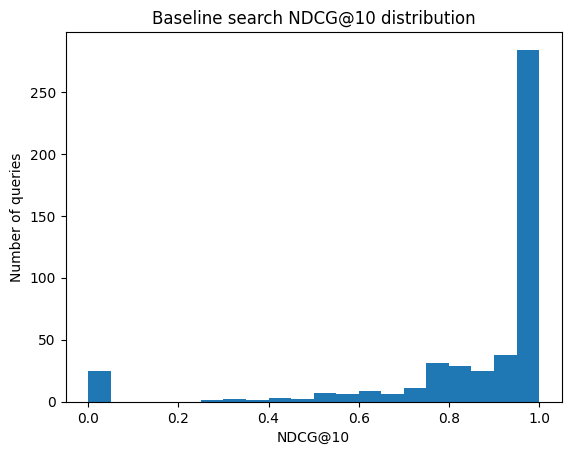

count    480.000000
mean       0.866431
std        0.242746
min        0.000000
25%        0.832898
50%        0.984218
75%        1.000000
max        1.000000
Name: ndcg, dtype: float64

In [43]:
# Task 5c: Analyze the distribution

# YOUR CODE HERE
# Task 5c: Analyze the distribution

import matplotlib.pyplot as plt

plt.hist(results_baseline['ndcg'], bins=20)
plt.xlabel("NDCG@10")
plt.ylabel("Number of queries")
plt.title("Baseline search NDCG@10 distribution")
plt.show()

results_baseline['ndcg'].describe()


---

## Task 6: Improve Search with Additional Fields

Our baseline only searches the `product_name` field. Let's improve by adding more fields!

### 6a. Index product_class field

The `product_class` field contains the category of the product (e.g., "Rugs", "Coffee Tables"). This is a powerful signal!

Create a search function that combines all three fields (name, description, class).

In [45]:
# Task 6a: Index product_class field (COMPLETE VERSION)
# Create ALL THREE indexes in one place

# 1. Name index (from Task 3a)
name_docs = products['product_name'].fillna("").tolist()
name_index, name_doc_lengths = build_index(name_docs, snowball_tokenize)

# 2. Description index (from Task 3b)  
desc_docs = products['product_description'].fillna("").tolist()
desc_index, desc_doc_lengths = build_index(desc_docs, snowball_tokenize)

# 3. Class index (NEW)
class_docs = products['product_class'].fillna("").tolist()
class_index, class_doc_lengths = build_index(class_docs, snowball_tokenize)

print("✓ All 3 indexes created!")

def search_three_fields(query: str, k: int = 10,
                        w_name: float = 1.0,
                        w_desc: float = 1.0,
                        w_class: float = 2.0) -> pd.DataFrame:
    """Search across all 3 fields with weights"""
    # Score each field
    scores_name = score_bm25(query, name_index, len(products),
                             name_doc_lengths, snowball_tokenize)
    scores_desc = score_bm25(query, desc_index, len(products),
                             desc_doc_lengths, snowball_tokenize)
    scores_class = score_bm25(query, class_index, len(products),
                              class_doc_lengths, snowball_tokenize)
    
    # Combine with weights
    combined = (w_name * scores_name + 
                w_desc * scores_desc + 
                w_class * scores_class)
    
    # Get top k
    top_k_idx = np.argsort(-combined)[:k]
    results = products.iloc[top_k_idx].copy()
    results['score'] = combined[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

# Test it works!
print("\nTesting 3-field search:")
test_results = search_three_fields("coffee table", k=5)
print(test_results[['product_id','product_name','product_class','score']].head())


✓ All 3 indexes created!

Testing 3-field search:
       product_id             product_name             product_class  \
34496       34496     picacho coffee table  Coffee & Cocktail Tables   
29952       29952    metpally coffee table  Coffee & Cocktail Tables   
26857       26857    elmcrest coffee table  Coffee & Cocktail Tables   
16877       16877    mendivil coffee table  Coffee & Cocktail Tables   
38673       38673  abdulsamet coffee table  Coffee & Cocktail Tables   

           score  
34496  26.434790  
29952  26.120741  
26857  26.009086  
16877  25.991832  
38673  25.991832  


### 6b. Evaluate three-field search

Now evaluate your three-field search on all queries to see how it compares to the baseline.

In [ ]:
# Task 6b: Evaluate three-field search

# YOUR CODE HERE

def three_field_search_func(query_text: str, k: int = 10) -> pd.DataFrame:
    return search_three_fields(query_text, k=k)

results_three = evaluate_search(
    search_func=three_field_search_func,
    products_df=products,
    queries_df=queries,
    labels_df=labels,
    k=10,
    verbose=True
)

results_three.head()


Evaluated 480 queries
Mean NDCG@10: 0.8660


,query_id,query,ndcg
0,0,salon chair,1.000000
1,1,smart coffee table,1.000000
2,2,dinosaur,1.000000
3,3,turquoise pillows,0.897263
4,4,chair and a half recliner,0.807212


### 6c. Compare to baseline

Analyze which queries improved and which degraded when using three-field search.

In [47]:
# Task 6c: Compare to baseline

comparison = results_baseline[['query_id','query','ndcg']].rename(
    columns={'ndcg': 'ndcg_baseline'}
).merge(
    results_three[['query_id','ndcg']].rename(columns={'ndcg':'ndcg_three'}),
    on='query_id',
    how='inner'
)

comparison['delta'] = comparison['ndcg_three'] - comparison['ndcg_baseline']

print("Mean NDCG baseline:", comparison['ndcg_baseline'].mean())
print("Mean NDCG three-field:", comparison['ndcg_three'].mean())
print("Mean delta:", comparison['delta'].mean())

# top improved
improved = comparison.sort_values('delta', ascending=False).head()
improved

# most degraded
degraded = comparison.sort_values('delta').head()
degraded


Mean NDCG baseline: 0.8664314223063878
Mean NDCG three-field: 0.8659588492393461
Mean delta: -0.00047257306704160534


,query_id,query,ndcg_baseline,ndcg_three,delta
445,452,day bed indian,1.000000,0.0,-1.000000
446,453,midcentury tv unit,1.000000,0.0,-1.000000
13,13,outdoor privacy wall,0.977015,0.0,-0.977015
287,291,front door cabinet with doors,0.916554,0.0,-0.916554
45,45,70s inspired furniture,0.799669,0.0,-0.799669


---

## Task 7: Query Understanding with LLM

Sometimes users search for "star wars rug" when they really want a "rug with Star Wars theme". An LLM can help us understand what the user is actually looking for!

### 7a. Extract product type from query

Write a function using LiteLLM with structured outputs (Pydantic) to extract key information from a query.

In [51]:
# Task 7a: Extract product attributes (FIXED for LiteLLM)
from pydantic import BaseModel, Field
from typing import Optional

class QueryAttributes(BaseModel):
    product_type: Optional[str] = Field(None, description="Main product type, e.g. 'rug', 'sofa'")
    theme: Optional[str] = Field(None, description="Theme, e.g. 'star wars', 'modern'")
    material: Optional[str] = Field(None, description="Main material, e.g. 'wood', 'leather'")
    color: Optional[str] = Field(None, description="Primary color, e.g. 'blue', 'brown'")
    style: Optional[str] = Field(None, description="Style words, e.g. 'modern', 'rustic'")

def extract_query_attributes(query: str) -> QueryAttributes:
    """Extract structured attributes from query using LLM"""
    response = litellm.completion(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": 
             "You are a furniture search expert. Extract structured attributes from short search queries. "
             "Respond ONLY with valid JSON matching this schema exactly, no extra text:\n"
             '{"product_type": "string|null", "theme": "string|null", "material": "string|null", '
             '"color": "string|null", "style": "string|null"}'},
            {"role": "user", "content": f"Query: '{query}'"}
        ],
        temperature=0.1,
        max_tokens=100
    )
    
    # Parse the LLM response as JSON and validate with Pydantic
    import json
    try:
        attrs_dict = json.loads(response.choices[0].message.content)
        return QueryAttributes(**attrs_dict)
    except:
        # Fallback if parsing fails
        return QueryAttributes()


In [52]:
# Test your query understanding function by running it against these test queries
test_queries = [
    "star wars rug",
    "wooden coffee table",
    "blue leather sofa",
    "modern metal bookshelf"
]

for q in test_queries:
    # YOUR CODE HERE
    pass

### 7b. Create an LLM-enhanced search

Use the extracted product type to boost matching results. If the LLM identifies "rug" as the product type, boost products where `product_class` contains "rug".

In [53]:
# Task 7b: LLM-enhanced search (COMPLETE & FIXED)
def search_with_llm_boost(query: str, k: int = 10) -> pd.DataFrame:
    """Search with LLM query understanding boost"""
    # 1. Get LLM attributes
    attrs = extract_query_attributes(query)
    print(f"Query: '{query}' → {attrs}")  # Debug print
    
    # 2. Get base scores from 3-field search
    base_scores = search_three_fields(query, k=len(products))['score'].to_numpy()
    
    # 3. Boost if product_class matches predicted product_type
    scores = base_scores.copy()
    if attrs.product_type:
        mask = products['product_class'].fillna("").str.lower().str.contains(
            attrs.product_type.lower(), na=False
        )
        boost = np.where(mask, 5.0, 0.0)  # Strong boost for category match
        scores += boost
    
    # 4. Get top k results
    top_k_idx = np.argsort(-scores)[:k]
    results = products.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

# Test it works!
print("Testing LLM-enhanced search:")
test_results = search_with_llm_boost("star wars rug", k=5)
print(test_results[['product_id','product_name','product_class','score']])


Testing LLM-enhanced search:
Query: 'star wars rug' → product_type='rug' theme='star wars' material=None color=None style=None
   product_id                                       product_name  \
0           0                            solid wood platform bed   
1           1                        all-clad 7 qt . slow cooker   
2           2            all-clad electrics 6.5 qt . slow cooker   
3           3       all-clad all professional tools pizza cutter   
4           4  baldwin prestige alcott passage knob with roun...   

                  product_class      score  
0                          Beds  32.866691  
1                  Slow Cookers  32.434552  
2                  Slow Cookers  30.875370  
3  Slicers, Peelers And Graters  30.804444  
4                    Door Knobs  29.464426  


In [56]:
# Test LLM on just 10 queries first
test_queries = queries.head(10)
results_llm_test = evaluate_search(
    llm_search_func, products, test_queries, labels, k=10
)
print("LLM test NDCG (10 queries):", results_llm_test['ndcg'].mean())


Query: 'salon chair' → product_type='chair' theme=None material=None color=None style='salon'
Query: 'smart coffee table' → product_type='coffee table' theme=None material=None color=None style='smart'
Query: 'dinosaur' → product_type=None theme='dinosaur' material=None color=None style=None
Query: 'turquoise pillows' → product_type='pillows' theme=None material=None color='turquoise' style=None
Query: 'chair and a half recliner' → product_type='chair' theme=None material=None color=None style='recliner'
Query: 'sofa with ottoman' → product_type='sofa' theme=None material=None color=None style=None
Query: 'acrylic clear chair' → product_type='chair' theme=None material='acrylic' color='clear' style=None
Query: 'driftwood mirror' → product_type='mirror' theme='driftwood' material=None color=None style=None
Query: 'home sweet home sign' → product_type='sign' theme='home' material=None color=None style=None
Query: 'coffee table fire pit' → product_type='coffee table' theme=None material=N

---
## Task 8: Submit via Pull Request

Now let's submit your work using the Git workflow from previous homeworks.
-git push origin homework-3

  
**The TA will verify your submission by checking the merged PR on your GitHub repo.**

**Also remember to submit your homework on Blackboard!**
